In [10]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Core ML and time series libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Time series specific
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False
    print("Prophet not available. Install with: pip install prophet")

# Deep learning for LSTM (optional)
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    # Remove the print statement to avoid showing this error

# Additional libraries
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations

In [44]:
class TechnologyEmergencePredictor:
    """
    A comprehensive system for predicting technology emergence in autonomous vehicle patents.
    
    Features:
    - Multiple forecasting models (Prophet, LSTM, ensemble methods)
    - Rich feature engineering from patent data
    - Technology growth analysis and ranking
    - Emergence event detection
    - Competitive landscape insights
    """
    
    def __init__(self, data_path: str = None, patents_data: List[Dict] = None):
        """
        Initialize the predictor with patent data.
        
        Args:
            data_path: Path to JSON file containing patent data
            patents_data: Direct list of patent dictionaries
        """
        self.patents_data = None
        self.df = None
        self.exploded_df = None  # Add this
        self.time_series_data = None
        self.models = {}
        self.predictions = {}
        self.feature_importance = {}
        self.emergence_scores = None
        
        if data_path:
            self.load_data(data_path)
        elif patents_data:
            self.patents_data = patents_data
            self.preprocess_data()
    
    def load_data(self, data_path: str):
        """Load patent data from JSON file."""
        with open(data_path, 'r', encoding='utf-8') as f:
            self.patents_data = json.load(f)
        print(f"Loaded {len(self.patents_data)} patents from {data_path}")
        self.preprocess_data()
    
    def preprocess_data(self):
        """Convert patent data to structured DataFrame with enhanced features."""
        print("Preprocessing patent data...")
        records = []
        
        for patent in self.patents_data:
            # Extract basic information
            record = {
                'lens_id': patent.get('lens_id'),
                'applicant_name': patent.get('applicant_name', ''),
                'date_published': pd.to_datetime(patent.get('date_published'), errors='coerce'),
                'earliest_claim_date': pd.to_datetime(patent.get('earliest_claim_date'), errors='coerce'),
                'primary_category': patent.get('primary_category', ''),
                'categorization_confidence': patent.get('categorization_confidence', 'Low'),
                'estimated_tokens': patent.get('estimated_tokens', 0)
            }
            
            # Process AV technology areas
            av_areas = patent.get('av_technology_areas', [])
            if isinstance(av_areas, list):
                record['av_tech_areas'] = av_areas
            else:
                record['av_tech_areas'] = [av_areas] if av_areas else []
            record['num_av_areas'] = len(record['av_tech_areas'])
            
            # Process secondary categories
            secondary_cats = patent.get('secondary_categories', [])
            if isinstance(secondary_cats, list):
                record['secondary_categories'] = secondary_cats
            else:
                record['secondary_categories'] = [secondary_cats] if secondary_cats else []
            record['num_secondary_categories'] = len(record['secondary_categories'])
            
            # Process CPC symbols
            cpc_symbols = patent.get('cpc_symbols', [])
            if isinstance(cpc_symbols, list):
                record['cpc_symbols'] = cpc_symbols
            else:
                record['cpc_symbols'] = [cpc_symbols] if cpc_symbols else []
            record['num_cpc_symbols'] = len(record['cpc_symbols'])
            
            # Process claims
            claims = patent.get('claims', [])
            if isinstance(claims, list):
                record['num_claims'] = len(claims)
                record['avg_claim_length'] = np.mean([len(str(claim).split()) for claim in claims]) if claims else 0
            else:
                record['num_claims'] = 1 if claims else 0
                record['avg_claim_length'] = len(str(claims).split()) if claims else 0
            
            # Text complexity features
            record['title_length'] = len(str(patent.get('invention_title_text', '')).split())
            record['abstract_length'] = len(str(patent.get('abstract_text', '')).split())
            record['description_length'] = len(str(patent.get('description', '')).split())
            
            # Time features
            if record['date_published'] and record['earliest_claim_date']:
                record['filing_to_pub_days'] = (record['date_published'] - record['earliest_claim_date']).days
            else:
                record['filing_to_pub_days'] = 0
            
            records.append(record)
        
        self.df = pd.DataFrame(records)
        print(f"Created DataFrame with {len(self.df)} records")
        
        # Debug: Check for empty av_tech_areas
        empty_av_areas = self.df[self.df['num_av_areas'] == 0]
        if len(empty_av_areas) > 0:
            print(f"Warning: {len(empty_av_areas)} patents have no AV technology areas")
        
        self._create_time_series_features()
    
    def _create_time_series_features(self):
        """Create time series data for each technology area."""
        print("Creating time series features...")
        
        # Use earliest_claim_date as the primary date for innovation timing
        self.df['date'] = self.df['earliest_claim_date'].fillna(self.df['date_published'])
        
        # Remove rows with no valid dates
        initial_count = len(self.df)
        self.df = self.df.dropna(subset=['date'])
        print(f"Removed {initial_count - len(self.df)} patents with no valid dates")
        
        if len(self.df) == 0:
            print("ERROR: No patents with valid dates found!")
            return
        
        # Create monthly time series
        self.df['year_month'] = self.df['date'].dt.to_period('M')
        
        # Explode AV technology areas to create one row per patent-technology combination
        exploded_data = []
        for _, row in self.df.iterrows():
            av_areas = row['av_tech_areas']
            if not av_areas:  # If no AV areas, use primary category
                av_areas = [row['primary_category']] if row['primary_category'] else ['Unknown']
            
            for tech_area in av_areas:
                if tech_area and tech_area.strip():  # Only add non-empty tech areas
                    new_row = row.copy()
                    new_row['technology'] = tech_area.strip()
                    exploded_data.append(new_row)
        
        if not exploded_data:
            print("ERROR: No valid technology areas found!")
            return
        
        self.exploded_df = pd.DataFrame(exploded_data)
        print(f"Created exploded DataFrame with {len(self.exploded_df)} technology-patent pairs")
        
        # Print technology distribution
        tech_counts = self.exploded_df['technology'].value_counts()
        print(f"Found {len(tech_counts)} unique technologies")
        print("Top 10 technologies by patent count:")
        print(tech_counts.head(10))
        
        # Create time series aggregations
        self.time_series_data = self._create_aggregated_time_series()
        print(f"Created time series for {len(self.time_series_data)} technologies")
    
    def _create_aggregated_time_series(self) -> Dict[str, pd.DataFrame]:
        """Fixed version of time series aggregation."""
        tech_time_series = {}
        
        if self.exploded_df is None or len(self.exploded_df) == 0:
            print("ERROR: No exploded data available!")
            return {}
        
        # CRITICAL FIX: Use 'technology' field from exploded data, not 'primary_category'
        all_technologies = self.exploded_df['technology'].unique()
        print(f"Processing {len(all_technologies)} unique technologies from exploded data")
        
        # Use the 'date' field that was set in _create_time_series_features
        if 'date' not in self.exploded_df.columns:
            print("ERROR: 'date' column missing from exploded_df")
            return {}
        
        # Ensure date is datetime
        self.exploded_df['date'] = pd.to_datetime(self.exploded_df['date'])
        
        min_date = self.exploded_df['date'].min()
        max_date = self.exploded_df['date'].max()
        
        print(f"Date range: {min_date} to {max_date}")
        
        # Create monthly date range
        date_range = pd.date_range(start=min_date, end=max_date, freq='MS')  # Month start
        print(f"Created date range with {len(date_range)} months")
        
        for tech in all_technologies:
            # CRITICAL FIX: Filter by 'technology' field, not 'primary_category'
            tech_data = self.exploded_df[self.exploded_df['technology'] == tech].copy()
            
            if len(tech_data) == 0:
                print(f"WARNING: No data found for technology '{tech}'")
                continue
            
            print(f"Processing {tech}: {len(tech_data)} patents")
            
            # Create 'year_month' from 'date' for proper grouping
            tech_data['year_month'] = tech_data['date'].dt.to_period('M').dt.to_timestamp()
            
            # Group by year_month and aggregate
            monthly_stats = tech_data.groupby('year_month').agg({
                'lens_id': 'count',                # patent count
                'applicant_name': 'nunique',      # unique applicants
                'num_claims': ['mean', 'sum'],
                'estimated_tokens': ['mean', 'sum'],
                'num_cpc_symbols': 'mean',
                'categorization_confidence': lambda x: (x == 'High').sum() / len(x) if len(x) > 0 else 0
            }).reset_index()
            
            # Flatten columns properly
            monthly_stats.columns = [
                'date', 'patent_count', 'unique_applicants',
                'avg_claims', 'total_claims', 'avg_tokens', 'total_tokens',
                'avg_cpc_symbols', 'high_confidence_ratio'
            ]
            
            print(f"  Aggregated to {len(monthly_stats)} months with data")
            print(f"  Total patents in aggregation: {monthly_stats['patent_count'].sum()}")
            
            # Complete date range with zero filling
            complete_series = pd.DataFrame({'date': date_range})
            monthly_stats = complete_series.merge(monthly_stats, on='date', how='left').fillna(0)
            
            # Add derived features
            monthly_stats['technology'] = tech
            monthly_stats['cumulative_patents'] = monthly_stats['patent_count'].cumsum()
            monthly_stats['rolling_3m_avg'] = monthly_stats['patent_count'].rolling(3, min_periods=1).mean()
            monthly_stats['rolling_6m_avg'] = monthly_stats['patent_count'].rolling(6, min_periods=1).mean()
            monthly_stats['patent_velocity'] = monthly_stats['patent_count'].diff().fillna(0)
            monthly_stats['applicant_diversity'] = monthly_stats['unique_applicants'] / (monthly_stats['patent_count'] + 1)
            
            # Calculate market concentration
            monthly_stats['market_concentration'] = self._calculate_market_concentration(tech_data, monthly_stats)
            
            final_patent_count = monthly_stats['patent_count'].sum()
            print(f"  {tech}: {final_patent_count} patents across {len(monthly_stats)} months")
            
            if final_patent_count > 0:  # Only add if we have actual patents
                tech_time_series[tech] = monthly_stats
            else:
                print(f"  WARNING: Skipping {tech} - no patents in final aggregation")
        
        print(f"Successfully created time series for {len(tech_time_series)} technologies")
        return tech_time_series
    
    def _calculate_market_concentration(self, tech_data: pd.DataFrame, monthly_stats: pd.DataFrame) -> pd.Series:
        """Calculate market concentration using Herfindahl index approximation."""
        concentration_scores = []
        
        for _, month_row in monthly_stats.iterrows():
            month_start = month_row['date']
            month_end = month_start + pd.DateOffset(months=1)
            
            # Use the correct date column
            month_patents = tech_data[
                (tech_data['date'] >= month_start) & 
                (tech_data['date'] < month_end)
            ]
            
            if len(month_patents) == 0:
                concentration_scores.append(0)
                continue
            
            # Calculate market shares by applicant
            applicant_counts = month_patents['applicant_name'].value_counts()
            if len(applicant_counts) == 0:
                concentration_scores.append(0)
                continue
                
            market_shares = applicant_counts / applicant_counts.sum()
            herfindahl_index = (market_shares ** 2).sum()
            concentration_scores.append(herfindahl_index)
        
        return pd.Series(concentration_scores)
    
    def debug_data_flow(self):
        """Debug method to trace data through the pipeline."""
        print("=== DATA FLOW DEBUG ===")
        
        if self.df is not None:
            print(f"Main DataFrame: {len(self.df)} rows")
            print(f"Date range: {self.df['date'].min()} to {self.df['date'].max()}")
            print(f"Primary categories: {self.df['primary_category'].nunique()} unique")
            print("Sample primary categories:", self.df['primary_category'].value_counts().head(3).to_dict())
        
        if self.exploded_df is not None:
            print(f"Exploded DataFrame: {len(self.exploded_df)} rows")
            print(f"Technologies: {self.exploded_df['technology'].nunique()} unique")
            print("Sample technologies:", self.exploded_df['technology'].value_counts().head(3).to_dict())
        
        if self.time_series_data:
            print(f"Time series data: {len(self.time_series_data)} technologies")
            for tech_name, tech_df in list(self.time_series_data.items())[:3]:
                total_patents = tech_df['patent_count'].sum()
                print(f"  {tech_name}: {total_patents} total patents, {len(tech_df)} time points")
        
        print("=== END DEBUG ===")
    
    def engineer_features(self, tech_df: pd.DataFrame) -> pd.DataFrame:
        """Engineer additional predictive features for a technology time series."""
        features_df = tech_df.copy()
        
        # Lag features
        for lag in [1, 2, 3, 6, 12]:
            if len(features_df) > lag:
                features_df[f'patent_count_lag_{lag}'] = features_df['patent_count'].shift(lag)
                features_df[f'unique_applicants_lag_{lag}'] = features_df['unique_applicants'].shift(lag)
        
        # Rolling statistics
        for window in [3, 6, 12]:
            if len(features_df) >= window:
                features_df[f'patent_count_rolling_std_{window}'] = features_df['patent_count'].rolling(window).std()
                features_df[f'patent_count_rolling_max_{window}'] = features_df['patent_count'].rolling(window).max()
                features_df[f'unique_applicants_rolling_mean_{window}'] = features_df['unique_applicants'].rolling(window).mean()
        
        # Trend features
        features_df['patent_count_trend'] = features_df['patent_count'].rolling(6, min_periods=3).apply(
            lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0
        )
        
        # Seasonal features
        features_df['month'] = features_df['date'].dt.month
        features_df['quarter'] = features_df['date'].dt.quarter
        features_df['year'] = features_df['date'].dt.year
        
        # Innovation intensity features
        features_df['innovation_intensity'] = (
            features_df['patent_count'] * features_df['avg_tokens'] * features_df['high_confidence_ratio']
        )
        
        # Competition features
        features_df['competitive_pressure'] = features_df['unique_applicants'] / (features_df['patent_count'] + 1)
        
        return features_df.fillna(0)
    
    def train_prophet_model(self, tech_name: str, forecast_periods: int = 12) -> Dict[str, Any]:
        """Train Prophet model for a specific technology."""
        if not PROPHET_AVAILABLE:
            raise ImportError("Prophet not available. Install with: pip install prophet")
        
        tech_df = self.time_series_data[tech_name].copy()
        
        # Prepare data for Prophet
        prophet_df = tech_df[['date', 'patent_count']].rename(columns={'date': 'ds', 'patent_count': 'y'})
        
        # Add additional regressors
        prophet_df['unique_applicants'] = tech_df['unique_applicants']
        prophet_df['avg_tokens'] = tech_df['avg_tokens']
        prophet_df['market_concentration'] = tech_df['market_concentration']
        
        # Initialize and fit Prophet model
        model = Prophet(
            yearly_seasonality=True,
            monthly_seasonality=True,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=10.0
        )
        
        # Add regressors
        model.add_regressor('unique_applicants')
        model.add_regressor('avg_tokens')
        model.add_regressor('market_concentration')
        
        model.fit(prophet_df)
        
        # Create future dataframe
        future = model.make_future_dataframe(periods=forecast_periods, freq='M')
        
        # Add regressor values for future periods (using last known values)
        last_values = prophet_df.iloc[-1]
        future['unique_applicants'] = future['unique_applicants'].fillna(last_values['unique_applicants'])
        future['avg_tokens'] = future['avg_tokens'].fillna(last_values['avg_tokens'])
        future['market_concentration'] = future['market_concentration'].fillna(last_values['market_concentration'])
        
        # Make predictions
        forecast = model.predict(future)
        
        return {
            'model': model,
            'forecast': forecast,
            'train_data': prophet_df,
            'future_periods': forecast_periods
        }
    
    def train_ml_ensemble(self, tech_name: str, forecast_periods: int = 12) -> Dict[str, Any]:
        """Train ensemble ML models for technology prediction."""
        tech_df = self.time_series_data[tech_name].copy()
        features_df = self.engineer_features(tech_df)
        
        # Prepare features and target
        feature_cols = [col for col in features_df.columns if col not in [
            'date', 'year_month', 'technology', 'patent_count'
        ]]
        
        X = features_df[feature_cols].fillna(0)
        y = features_df['patent_count']
        
        # Time series split for validation
        tscv = TimeSeriesSplit(n_splits=3)
        
        # Models
        models = {
            'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'gradient_boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        
        trained_models = {}
        feature_importance = {}
        
        for name, model in models.items():
            # Cross-validation
            scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
            
            # Fit on full data
            model.fit(X, y)
            trained_models[name] = model
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': feature_cols,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                feature_importance[name] = importance_df
        
        # Create predictions
        last_features = X.iloc[-1:].copy()
        predictions = {}
        
        for name, model in trained_models.items():
            model_predictions = []
            current_features = last_features.copy()
            
            for _ in range(forecast_periods):
                pred = model.predict(current_features)[0]
                model_predictions.append(max(0, pred))  # Ensure non-negative
                
                # Update features for next prediction (simple approach)
                current_features = current_features.copy()
                # This is a simplified feature update - in practice, you'd want more sophisticated logic
            
            predictions[name] = model_predictions
        
        # Ensemble prediction (average)
        ensemble_prediction = np.mean([predictions[name] for name in predictions], axis=0)
        
        return {
            'models': trained_models,
            'predictions': predictions,
            'ensemble_prediction': ensemble_prediction,
            'feature_importance': feature_importance,
            'feature_columns': feature_cols
        }
    
    def calculate_emergence_scores(self) -> pd.DataFrame:
        """Calculate comprehensive emergence scores for all technologies."""
        print("Calculating emergence scores...")
        
        if not self.time_series_data:
            print("ERROR: No time series data available!")
            return pd.DataFrame()
        
        emergence_data = []
        
        for tech_name, tech_df in self.time_series_data.items():
            print(f"Processing {tech_name}: {len(tech_df)} data points")
            
            # Relaxed minimum data requirements
            if len(tech_df) < 2:
                print(f"  Skipping {tech_name}: insufficient data points ({len(tech_df)})")
                continue
            
            # Filter out rows with zero patent counts for better analysis
            active_data = tech_df[tech_df['patent_count'] > 0]
            if len(active_data) < 1:
                print(f"  Skipping {tech_name}: no active periods")
                continue
            
            print(f"  {tech_name}: {len(active_data)} active periods")
            
            # Split data into periods for growth calculation
            total_months = len(tech_df)
            split_point = max(1, total_months // 2)
            
            earlier_data = tech_df.iloc[:split_point]
            recent_data = tech_df.iloc[split_point:]
            
            # Growth metrics - use sum instead of mean for more meaningful comparison
            recent_sum = recent_data['patent_count'].sum()
            earlier_sum = earlier_data['patent_count'].sum()
            
            # Normalize by time periods to get rate per month
            recent_avg = recent_sum / len(recent_data) if len(recent_data) > 0 else 0
            earlier_avg = earlier_sum / len(earlier_data) if len(earlier_data) > 0 else 0
            
            # Calculate growth rate with better handling
            if earlier_avg > 0:
                growth_rate = (recent_avg - earlier_avg) / earlier_avg
            elif recent_avg > 0:
                growth_rate = 1.0  # 100% growth from zero baseline
            else:
                growth_rate = 0
            
            # Acceleration (second derivative)
            patent_counts = active_data['patent_count'].values
            if len(patent_counts) >= 3:
                # Calculate acceleration more robustly
                velocity = np.diff(patent_counts)
                acceleration = np.mean(np.diff(velocity)) if len(velocity) > 1 else 0
            else:
                acceleration = 0
            
            # Diversity metrics - use recent data
            recent_applicant_diversity = recent_data['applicant_diversity'].mean()
            recent_market_concentration = recent_data['market_concentration'].mean()
            
            # Innovation quality - fix the token calculation
            recent_avg_tokens = recent_data['avg_tokens'].mean()
            if recent_avg_tokens == 0 or np.isnan(recent_avg_tokens):
                # Fallback to total tokens divided by patents
                recent_avg_tokens = (recent_data['total_tokens'].sum() / 
                                   max(recent_data['patent_count'].sum(), 1))
            
            recent_confidence = recent_data['high_confidence_ratio'].mean()
            
            # Volatility (coefficient of variation) - use active data only
            if len(patent_counts) > 1 and np.mean(patent_counts) > 0:
                volatility = np.std(patent_counts) / np.mean(patent_counts)
            else:
                volatility = 0
            
            # Trend strength - use active data
            x = np.arange(len(patent_counts))
            if len(patent_counts) >= 2:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, patent_counts)
                trend_strength = abs(r_value)
                trend_significance = 1 - p_value if p_value < 0.05 else 0
            else:
                trend_strength = 0
                trend_significance = 0
            
            # Composite emergence score with better normalization
            # Normalize growth rate to [0, 1] range
            normalized_growth = min(max(growth_rate, -1), 2) / 3 + 1/3  # Maps [-1, 2] to [0, 1]
            
            # Normalize acceleration
            normalized_acceleration = min(max(acceleration, -1), 1) / 2 + 0.5  # Maps [-1, 1] to [0, 1]
            
            # Normalize token count (assume reasonable range 0-2000)
            normalized_tokens = min(recent_avg_tokens / 2000, 1)
            
            emergence_score = (
                0.30 * normalized_growth +
                0.20 * normalized_acceleration +
                0.15 * recent_applicant_diversity +
                0.15 * (1 - recent_market_concentration) +
                0.10 * normalized_tokens +
                0.10 * recent_confidence
            )
            
            emergence_data.append({
                'technology': tech_name,
                'emergence_score': emergence_score,
                'growth_rate': growth_rate,
                'acceleration': acceleration,
                'recent_avg_patents': recent_avg,
                'applicant_diversity': recent_applicant_diversity,
                'market_concentration': recent_market_concentration,
                'avg_innovation_quality': recent_avg_tokens,
                'confidence_ratio': recent_confidence,
                'trend_strength': trend_strength,
                'trend_significance': trend_significance,
                'volatility': volatility,
                'total_patents': tech_df['patent_count'].sum(),
                'data_points': len(tech_df)
            })
        
        if not emergence_data:
            print("WARNING: No emergence data calculated!")
            return pd.DataFrame()
        
        emergence_df = pd.DataFrame(emergence_data)
        emergence_df = emergence_df.sort_values('emergence_score', ascending=False)
        
        print(f"Calculated emergence scores for {len(emergence_df)} technologies")
        self.emergence_scores = emergence_df
        return emergence_df
    
    def predict_all_technologies(self, forecast_periods: int = 12, methods: List[str] = None) -> Dict[str, Dict]:
        """Run predictions for all technologies using specified methods."""
        if methods is None:
            methods = ['ensemble']
            if PROPHET_AVAILABLE:
                methods.append('prophet')
        
        all_predictions = {}
        
        for tech_name in self.time_series_data.keys():
            tech_predictions = {}
            
            if 'prophet' in methods and PROPHET_AVAILABLE:
                try:
                    prophet_result = self.train_prophet_model(tech_name, forecast_periods)
                    tech_predictions['prophet'] = prophet_result
                except Exception as e:
                    print(f"Prophet failed for {tech_name}: {e}")
            
            if 'ensemble' in methods:
                try:
                    ensemble_result = self.train_ml_ensemble(tech_name, forecast_periods)
                    tech_predictions['ensemble'] = ensemble_result
                except Exception as e:
                    print(f"Ensemble failed for {tech_name}: {e}")
            
            if tech_predictions:
                all_predictions[tech_name] = tech_predictions
        
        self.predictions = all_predictions
        return all_predictions
    
    def get_top_emerging_technologies(self, top_n: int = 10) -> pd.DataFrame:
        """Get top N emerging technologies based on comprehensive scoring."""
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            print("Calculating emergence scores...")
            self.calculate_emergence_scores()
        
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            print("WARNING: No emergence scores available!")
            return pd.DataFrame()
        
        return self.emergence_scores.head(top_n)
    
    def generate_insights_report(self) -> Dict[str, Any]:
        """Generate comprehensive insights report."""
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            self.calculate_emergence_scores()
        
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            return {
                'error': 'No emergence scores available',
                'summary': {
                    'total_technologies': len(self.time_series_data) if self.time_series_data else 0,
                    'total_patents': len(self.df) if self.df is not None else 0,
                }
            }
        
        report = {
            'summary': {
                'total_technologies': len(self.time_series_data),
                'total_patents': self.df.shape[0],
                'date_range': {
                    'start': str(self.df['date'].min().date()),
                    'end': str(self.df['date'].max().date())
                },
                'top_applicants': self.df['applicant_name'].value_counts().head(10).to_dict()
            },
            'emergence_analysis': {
                'highest_growth_technologies': self.emergence_scores.nlargest(5, 'growth_rate')[
                    ['technology', 'growth_rate', 'emergence_score']
                ].to_dict('records'),
                'most_diverse_technologies': self.emergence_scores.nlargest(5, 'applicant_diversity')[
                    ['technology', 'applicant_diversity', 'emergence_score']
                ].to_dict('records'),
                'highest_quality_innovations': self.emergence_scores.nlargest(5, 'avg_innovation_quality')[
                    ['technology', 'avg_innovation_quality', 'emergence_score']
                ].to_dict('records')
            },
            'market_dynamics': {
                'most_concentrated_markets': self.emergence_scores.nlargest(5, 'market_concentration')[
                    ['technology', 'market_concentration']
                ].to_dict('records'),
                'most_competitive_markets': self.emergence_scores.nsmallest(5, 'market_concentration')[
                    ['technology', 'market_concentration', 'applicant_diversity']
                ].to_dict('records')
            }
        }
        
        return report
    
    def visualize_emergence_landscape(self, save_path: str = None):
        """Create comprehensive visualization of the technology emergence landscape."""
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            print("No emergence scores available, calculating...")
            self.calculate_emergence_scores()
        
        if self.emergence_scores is None or len(self.emergence_scores) == 0:
            print("ERROR: Cannot create visualization - no emergence scores available!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Technology Emergence Landscape', fontsize=16, fontweight='bold')
        
        # 1. Emergence Score vs Growth Rate
        ax1 = axes[0, 0]
        plot_data = self.emergence_scores[
            (self.emergence_scores['growth_rate'] >= -2) & 
            (self.emergence_scores['growth_rate'] <= 5) &
            (self.emergence_scores['avg_innovation_quality'] > 0)
        ]
        
        if len(plot_data) > 0:
            scatter = ax1.scatter(
                plot_data['growth_rate'], 
                plot_data['emergence_score'],
                s=plot_data['total_patents'] * 3 + 20,
                alpha=0.7,
                c=plot_data['applicant_diversity'],
                cmap='viridis'
            )
            ax1.set_xlabel('Growth Rate')
            ax1.set_ylabel('Emergence Score')
            ax1.set_title('Emergence Score vs Growth Rate\n(Size = Total Patents, Color = Applicant Diversity)')
            plt.colorbar(scatter, ax=ax1)
        else:
            ax1.text(0.5, 0.5, 'No data available for plotting', 
                     ha='center', va='center', transform=ax1.transAxes)
        
        # 2. Top 10 Emerging Technologies
        ax2 = axes[0, 1]
        top_10 = self.emergence_scores.head(10)
        bars = ax2.barh(range(len(top_10)), top_10['emergence_score'], color='skyblue')
        ax2.set_yticks(range(len(top_10)))
        ax2.set_yticklabels([tech[:20] + '...' if len(tech) > 20 else tech for tech in top_10['technology']])
        ax2.set_xlabel('Emergence Score')
        ax2.set_title('Top 10 Emerging Technologies')
        ax2.invert_yaxis()
        
        # 3. Market Concentration vs Innovation Quality
        ax3 = axes[1, 0]
        ax3.scatter(
            self.emergence_scores['market_concentration'],
            self.emergence_scores['avg_innovation_quality'],
            s=self.emergence_scores['emergence_score'] * 100,
            alpha=0.6,
            color='purple'
        )
        ax3.set_xlabel('Market Concentration')
        ax3.set_ylabel('Average Innovation Quality (Tokens)')
        ax3.set_title('Market Concentration vs Innovation Quality\n(Size = Emergence Score)')
        
        # 4. Technology Portfolio Quadrant Analysis
        ax4 = axes[1, 1]
        median_growth = self.emergence_scores['growth_rate'].median()
        median_diversity = self.emergence_scores['applicant_diversity'].median()
        
        colors = []
        for _, row in self.emergence_scores.iterrows():
            if row['growth_rate'] >= median_growth and row['applicant_diversity'] >= median_diversity:
                colors.append('green')
            elif row['growth_rate'] >= median_growth:
                colors.append('orange')
            elif row['applicant_diversity'] >= median_diversity:
                colors.append('blue')
            else:
                colors.append('red')
        
        ax4.scatter(
            self.emergence_scores['growth_rate'],
            self.emergence_scores['applicant_diversity'],
            c=colors,
            alpha=0.6
        )
        ax4.axvline(median_growth, color='black', linestyle='--', alpha=0.5)
        ax4.axhline(median_diversity, color='black', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Growth Rate')
        ax4.set_ylabel('Applicant Diversity')
        ax4.set_title('Technology Portfolio Quadrant Analysis')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

Loaded 667 patents from av_patent_data.json
Preprocessing patent data...
Created DataFrame with 667 records
Creating time series features...
Removed 0 patents with no valid dates
Created exploded DataFrame with 2765 technology-patent pairs
Found 15 unique technologies
Top 10 technologies by patent count:
technology
ai_ml_architecture         574
data_processing            563
software_algorithms        349
perception_sensing         266
vehicle_control_systems    222
hardware_sensors           169
path_planning_control      117
simulation_testing         113
v2x_communication           94
human_machine_interface     92
Name: count, dtype: int64
Processing 15 unique technologies from exploded data
Date range: 2014-12-05 00:00:00 to 2022-12-15 00:00:00
Created date range with 96 months
Processing v2x_communication: 94 patents
  Aggregated to 44 months with data
  Total patents in aggregation: 94
  v2x_communication: 93.0 patents across 96 months
Processing ai_ml_architecture: 574 patents

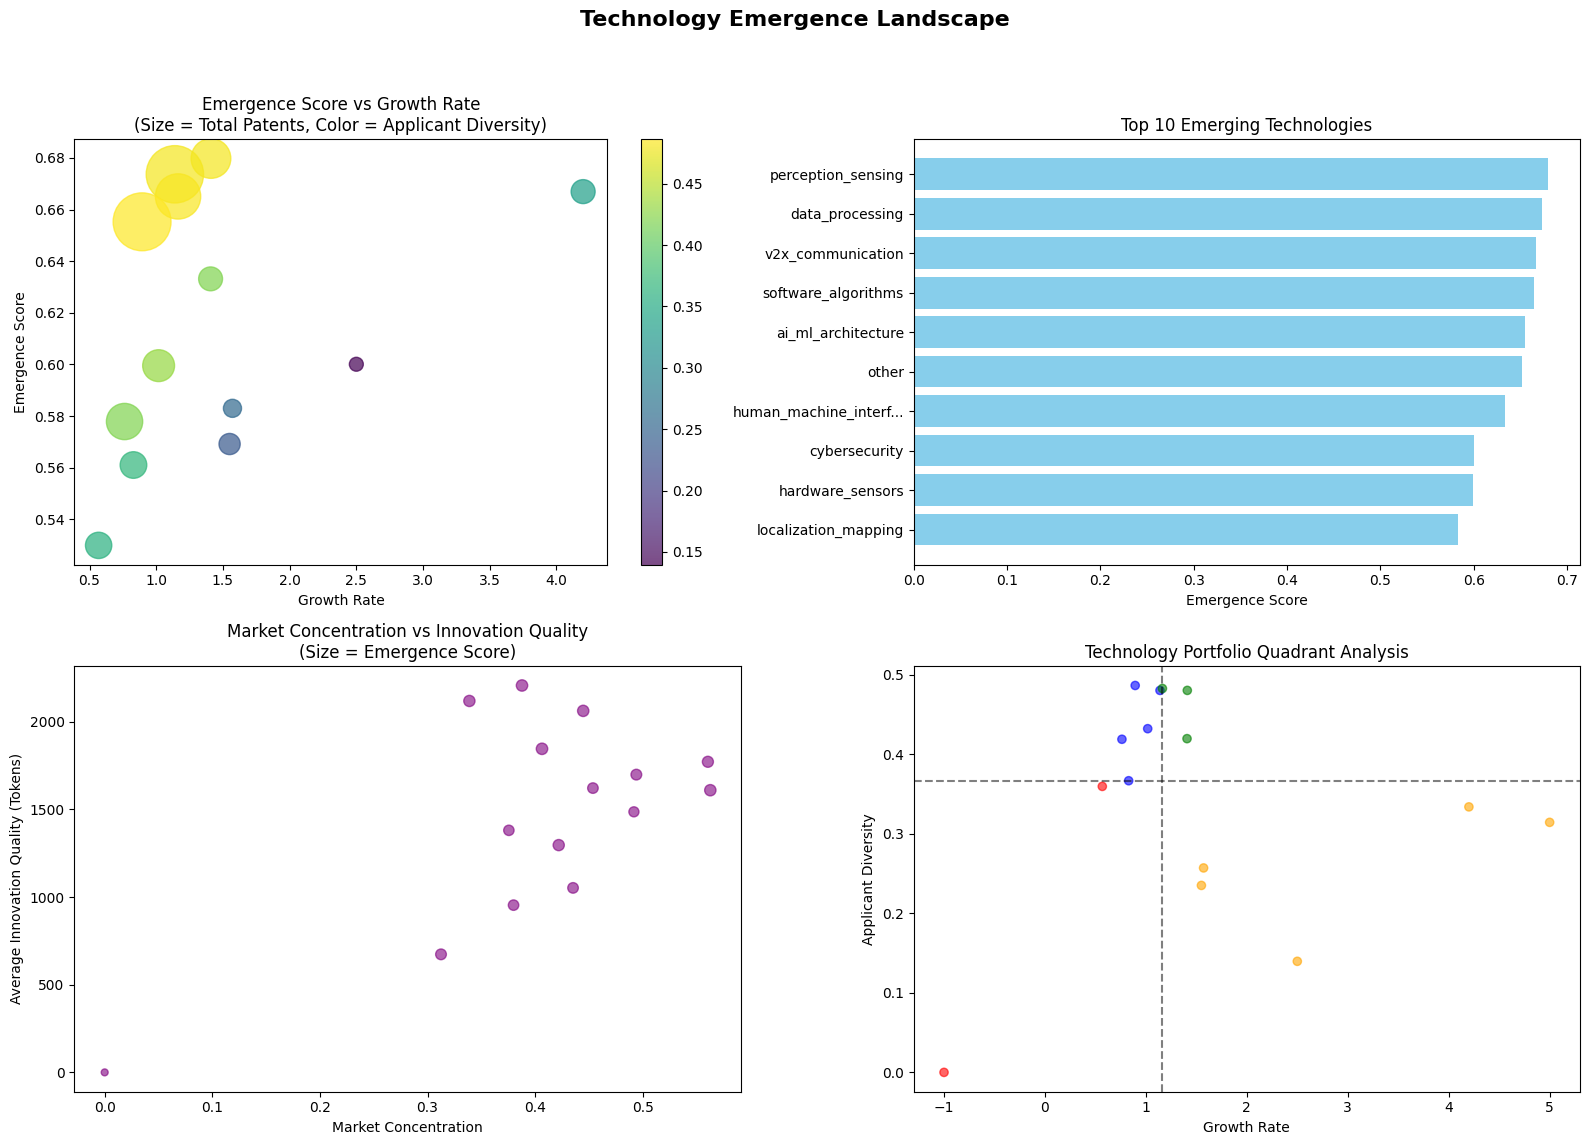

In [46]:
# Example usage and testing functions
def example_usage():
    """Example of how to use the TechnologyEmergencePredictor class."""
    
    # Initialize predictor (assuming you have the JSON file)
    predictor = TechnologyEmergencePredictor('av_patent_data.json')
    
    # Calculate emergence scores
    emergence_scores = predictor.calculate_emergence_scores()
    if not emergence_scores.empty:
        print(emergence_scores[['technology', 'emergence_score', 'growth_rate']].head(10))
    else:
        print("No emergence scores available.")
    print("Top 10 Emerging Technologies:")
    print(emergence_scores[['technology', 'emergence_score', 'growth_rate']].head(10))
    
    # Run predictions for all technologies
    predictions = predictor.predict_all_technologies(forecast_periods=12, methods=['ensemble'])
    
    # Generate insights report
    report = predictor.generate_insights_report()
    print("\nInsights Report Summary:")
    print(f"Total Technologies Analyzed: {report['summary']['total_technologies']}")
    print(f"Total Patents: {report['summary']['total_patents']}")
    print(f"Date Range: {report['summary']['date_range']['start']} to {report['summary']['date_range']['end']}")
    
    # Visualize results
    predictor.visualize_emergence_landscape("emergence.png")
    
    return predictor, emergence_scores, predictions, report

if __name__ == "__main__":
    # Run example if this file is executed directly
    example_usage()